In this notebook, we try to use subnetwork flow to figure out how L27H29ATN ends up attending to the forbidden token.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformer_lens.hook_points import HookPoint
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import ablation, decomp, prompt_data, utils
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

LAYER = 27
HEAD = 29
COMP_STR = f"L{LAYER}H{HEAD}"

### Load model

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
# tl_model.requires_grad_(False)
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


### Load facts and develop prompts

In [4]:
irrelevant_words = ["apple", "river", "car", "dog", "house", "tree", "book"]

df_raw = pd.read_csv("../../data/facts.csv")
assert set(df_raw.answer) & set(irrelevant_words) == set()
df_raw

,question,answer,type
0,Tom Brady plays the sport of,football,sport
1,LeBron James plays the sport of,basketball,sport
2,Lionel Messi plays the sport of,football,sport
3,Serena Williams plays the sport of,tennis,sport
4,Michael Phelps competes in the sport of,swimming,sport
...,...,...,...
186,Mick Mars plays the,guitar,instrument
187,John Densmore plays the,drums,instrument
188,Jack Bruce plays the,bass,instrument
189,Lars Ulrich plays the,drums,instrument


In [5]:
def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You are not allowed to say the forbidden word {forbidden_word}.
<</SYS>>
{question} [/INST] \
"""


# df_raw["fb_word"] = [
#     irrelevant_words[i % len(irrelevant_words)] for i in range(len(df_raw))
# ]
df_raw["fb_word"] = "apple"
df_raw["prompt_nc"] = [
    get_dontsay_prompt(q, fw) for q, fw in zip(df_raw.question, df_raw.fb_word)
]
df_raw["prompt_c"] = [
    get_dontsay_prompt(q, answer)
    for q, answer in zip(df_raw.question, df_raw.answer)
]

idx = 0
tl_model.remove_all_hook_fns(including_permanent=True)
for i, prompt in enumerate([df_raw.prompt_nc[idx], df_raw.prompt_c[idx]]):
    print(prompt)
    utils.get_top_responses(
        prompt=prompt, model=tl_model, top_k=5, n_continuation_tokens=20
    )
    print() if i == 0 else None

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 26.48 Prob: 99.67% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 20.00 Prob:  0.15% Tokens: (18322) |FO|OT|B|ALL|</s>|
Rank 2. Logit: 19.85 Prob:  0.13% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 17.54 Prob:  0.01% Tokens: (13440) |Foot|ball|</s>|
Rank 4. Logit: 17.15 Prob:  0.01% Tokens: (25167) |NFL|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word football.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 17.79 Prob: 63.15% Tokens: (23185) |Baseball|</s>|
Rank 1. Logit: 16.07 Prob: 11.32% Tokens: (21850) |Basketball|</s>|
Rank 2. Logit: 15.47 Prob:  6.22% Tokens: (  376) |"|B|asketball|"|</s>|
Rank 3. Logit: 15.30 Prob:  5.27% Tokens: (18585) |Sure|!|Tom|Br|ady|plays|...|(|p|aus|es|for|

In [6]:
def get_forbidden_token_range(prompt: str, forbidden_word: str) -> slice:
    tokens = tl_model.to_tokens(prompt)[0]
    start = 35
    for end in range(36, len(tokens) + 1):
        if tl_model.to_string(tokens[start:end]) == forbidden_word:
            return slice(start, end)
    raise ValueError("forbidden word not found")


metrics = []
for idx in tqdm(range(len(df_raw))):
    prompt_nc = df_raw.prompt_nc[idx]
    prompt_c = df_raw.prompt_c[idx]

    frng_c = get_forbidden_token_range(prompt_c, df_raw.answer[idx])
    frng_nc = get_forbidden_token_range(prompt_nc, df_raw.fb_word[idx])

    with torch.no_grad():
        logits_c, cache_c = tl_model.run_with_cache(
            prompt_c,
            names_filter=[tl_utils.get_act_name("pattern", LAYER)],
            remove_batch_dim=True,
        )
        logits_nc, cache_nc = tl_model.run_with_cache(
            prompt_nc,
            names_filter=[tl_utils.get_act_name("pattern", LAYER)],
            remove_batch_dim=True,
        )

        logits_nc = logits_nc[0, -1]
        logits_c = logits_c[0, -1]

        pattern_c = cache_c["pattern", LAYER][HEAD, -1]
        pattern_nc = cache_nc["pattern", LAYER][HEAD, -1]

        f_attn_prob_c = pattern_c[frng_c].sum()
        f_attn_prob_nc = pattern_nc[frng_nc].sum()

        top_tok_nc = logits_nc.argmax().item()
        top_tok_c = logits_c.argmax().item()

        top_tok_nc_prob_nc = logits_nc.softmax(dim=-1)[top_tok_nc]
        top_tok_nc_prob_c = logits_c.softmax(dim=-1)[top_tok_nc]

        log_bf_fb = top_tok_nc_prob_c.logit() - top_tok_nc_prob_nc.logit()

    metrics.append(
        dict(
            top_tok_nc=top_tok_nc,
            top_tok_c=top_tok_c,
            logits_c=logits_c.detach().cpu().numpy(),
            logits_nc=logits_nc.detach().cpu().numpy(),
            top_tok_nc_prob_nc=top_tok_nc_prob_nc.item(),
            top_tok_nc_prob_c=top_tok_nc_prob_c.item(),
            log_bf_fb=log_bf_fb.item(),
            top_str_nc=tl_model.to_string(top_tok_nc),
            top_str_c=tl_model.to_string(top_tok_c),
            pattern_c=pattern_c.detach().cpu().numpy(),
            pattern_nc=pattern_nc.detach().cpu().numpy(),
            f_attn_prob_c=f_attn_prob_c.item(),
            f_attn_prob_nc=f_attn_prob_nc.item(),
            frng_c=frng_c,
            frng_nc=frng_nc,
            flen_c=frng_c.stop - frng_c.start,
            flen_nc=frng_nc.stop - frng_nc.start,
            n_tokens_c=len(tl_model.to_tokens(prompt_c)[0]),
            n_tokens_nc=len(tl_model.to_tokens(prompt_nc)[0]),
        )
    )

df_raw = df_raw.assign(**pd.DataFrame(metrics))

  0%|          | 0/191 [00:00<?, ?it/s]

In [7]:
df_raw["correct_nc"] = [
    answer.lower().startswith(top_str_nc.lower())
    for top_str_nc, answer in zip(df_raw.top_str_nc, df_raw.answer)
]
print(f"# correct: {df_raw.correct_nc.sum()} / {len(df_raw)}")
df = df_raw.query("correct_nc").reset_index(drop=True)
df_raw.query("~correct_nc")[["question", "answer", "top_str_nc"]]

# correct: 186 / 191


,question,answer,top_str_nc
128,The element with atomic symbol Kr is,krypton,Pot
134,The element with atomic symbol Pm is,promethium,Pl
170,Chet Baker plays the,trumpet,Jazz
171,Lee Morgan plays the,trumpet,Jazz
188,Jack Bruce plays the,bass,Gu


### Filter to questions that have high attention to forbidden tokens

In [8]:
thresh = 0.3

print(
    f"# c. prompts with > {thresh * 100}% forbidden attn:",
    (df.f_attn_prob_c > thresh).sum(),
)

print(
    f"# n.c. prompts with > {thresh * 100}% forbidden attn:",
    (df.f_attn_prob_nc > thresh).sum(),
)

hi_attn_df = df.query("(f_attn_prob_c > @thresh) & (flen_c == 1)").reset_index(
    drop=True
)
print(len(hi_attn_df))
print(hi_attn_df.type.value_counts())
hi_attn_df[["question", "answer"]].head()

# c. prompts with > 30.0% forbidden attn: 110
# n.c. prompts with > 30.0% forbidden attn: 6
89
type
sport         35
instrument    31
country       21
element        2
Name: count, dtype: int64


,question,answer
0,LeBron James plays the sport of,basketball
1,Serena Williams plays the sport of,tennis
2,Babe Ruth played the sport of,baseball
3,Roger Federer plays the sport of,tennis
4,Venus Williams plays the sport of,tennis


In [9]:
hi_attn_df.n_tokens_c.value_counts()

n_tokens_c
58    19
56    14
57    12
55    11
59    11
54     9
60     6
53     3
61     2
62     2
Name: count, dtype: int64

In [10]:
hi_attn_df = hi_attn_df.query("n_tokens_c == 58").reset_index(drop=True)
hi_attn_df[["question", "answer", "f_attn_prob_c"]]

,question,answer,f_attn_prob_c
0,Roger Federer plays the sport of,tennis,0.333909
1,Alex Ovechkin plays the sport of,hockey,0.586974
2,Rafael Nadal plays the sport of,tennis,0.388849
3,Pete Sampras played the sport of,tennis,0.407343
4,Bryce Harper plays the sport of,baseball,0.713604
5,Mookie Betts plays the sport of,baseball,0.732516
6,Luka Dončić plays the sport of,basketball,0.746284
7,Larry Fitzgerald plays the sport of,football,0.323855
8,Jacob deGrom plays the sport of,baseball,0.653835
9,Kawhi Leonard plays the sport of,basketball,0.916609


### Begin subnetwork flow

In [34]:
mtl_model = PerTokenMaskedTransformer(
    tl_model,
    base_prompt=hi_attn_df.prompt_c[0],
)


def get_active_masks():
    for name, p in mtl_model.masks.items():
        if "mlp" in name:
            continue
        yield p


print(hi_attn_df.prompt_c[0])
utils.get_top_responses(
    prompt=hi_attn_df.prompt_c[0],
    model=mtl_model.tl_model,
    top_k=5,
    use_kv_cache=False,
)
optim = torch.optim.Adam(get_active_masks(), lr=1e-2)

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word tennis.
<</SYS>>
Roger Federer plays the sport of [/INST] 
Rank 0. Logit: 14.74 Prob: 21.11% Tokens: (29010) |Tennis|</s>|
Rank 1. Logit: 14.53 Prob: 17.12% Tokens: (  376) |"|T|ennis|"|</s>|
Rank 2. Logit: 14.34 Prob: 14.11% Tokens: (  997) |La|wn|</s>|
Rank 3. Logit: 13.99 Prob:  9.95% Tokens: (18585) |Sure|!|Here|is|my|response|
Rank 4. Logit: 13.56 Prob:  6.51% Tokens: (18993) |Soccer|</s>|


In [35]:
# Initialize optimizer
alpha = 0.1
n_steps = 400
p_norm = 1
batch_size = 2
pi = torch.tensor(np.pi, device=mtl_model.device)

np.random.seed(42)
torch.random.manual_seed(42)

mtl_model.train()
metric_history: list[dict[str]] = []
pbar = tqdm(range(n_steps))
for i in pbar:
    # Sample batch
    batch_indices = np.random.choice(
        len(hi_attn_df), size=batch_size, replace=False
    )
    batch_prompts = [hi_attn_df.prompt_c[i] for i in batch_indices]

    f_attn_prob_mean = 0

    def get_f_attn_prob(
        pattern: Float[torch.Tensor, "b head seqQ seqK"],
        hook: HookPoint,
    ):
        global f_attn_prob_mean
        f_attn_prob_mean = pattern[:, HEAD, -1, 35].mean()
        return pattern

    mtl_model.tl_model.run_with_hooks(
        batch_prompts,
        fwd_hooks=[[tl_utils.get_act_name("pattern", LAYER), get_f_attn_prob]],
    )

    # Regularization term
    mask_p_norm = sum(
        (mask**p_norm).sum() for mask in get_active_masks()
    ) ** (1 / p_norm)
    mask_nonzero = sum((mask > 0).sum() for mask in get_active_masks())
    mask_numel = sum(mask.numel() for mask in get_active_masks())
    density = mask_nonzero / mask_numel
    scaled_p_norm = alpha * torch.sin(pi * i / n_steps) * mask_p_norm

    loss = -f_attn_prob_mean + scaled_p_norm

    # Gradient update step
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Clamp the masks to be between 0 and 1
    with torch.no_grad():
        for mask in get_active_masks():
            mask.clamp_(0, 1)

    # Force attention in target head to be unchanged
    # with torch.no_grad():
    #     mtl_model.masks[f"{LAYER}_attn_pattern"][HEAD, -1, :] = 1

    # Logging
    metrics = dict(
        step=i,
        loss=loss.item(),
        f_attn_prob_mean=f_attn_prob_mean.item(),
        scaled_p_norm=scaled_p_norm.item(),
        mask_p_norm=mask_p_norm.item(),
        mask_nonzero=mask_nonzero.item(),
        mask_numel=mask_numel,
        density=density.item(),
    )
    metric_history.append(metrics)
    pbar.set_postfix(metrics)

  0%|          | 0/400 [00:00<?, ?it/s]

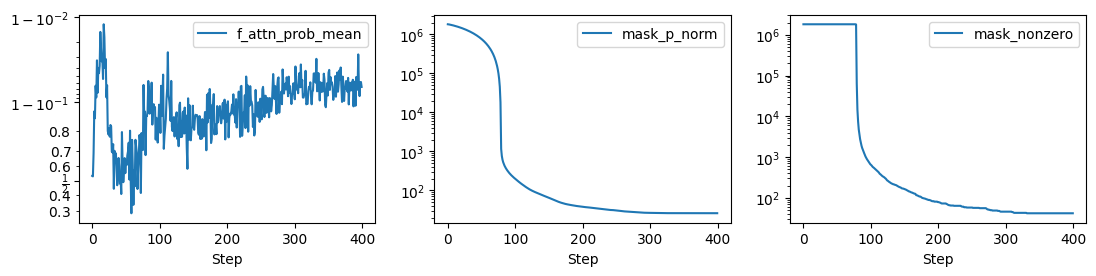

In [36]:
df = pd.DataFrame(metric_history)

plt.figure(figsize=(13, 2.7))
plt.subplot(1, 3, 1)
df.f_attn_prob_mean.plot()
plt.yscale("logit")
plt.legend()
plt.xlabel("Step")

plt.subplot(1, 3, 2)
df.mask_p_norm.plot()
plt.yscale("log")
plt.legend()
plt.xlabel("Step")

plt.subplot(1, 3, 3)
df.mask_nonzero.plot()
plt.yscale("log")
plt.legend()
plt.xlabel("Step")

plt.show()

In [37]:
attn_mask = np.stack(
    [mtl_model.masks[f"{i}_attn_out"].detach().cpu().numpy() for i in range(32)]
)
attn_z_mask = np.stack(
    [mtl_model.masks[f"{i}_attn_z"].detach().cpu().numpy() for i in range(32)], axis=0
)
attn_pattern_mask = np.stack(
    [mtl_model.masks[f"{i}_attn_pattern"].detach().cpu().numpy() for i in range(32)],
)
mlp_mask = np.stack(
    [mtl_model.masks[f"{i}_mlp_out"].detach().cpu().numpy() for i in range(32)]
)

attn_z_mask *= (attn_mask > 0)[:, :, np.newaxis]
attn_mask.shape, attn_z_mask.shape, attn_pattern_mask.shape, mlp_mask.shape

((32, 58), (32, 58, 32), (32, 32, 58, 58), (32, 58))

T54 L0H25ATN weight=0.2096542865037918
T56 L0H25ATN weight=0.5915775895118713
T56 L1H27ATN weight=0.8020796775817871
T56 L2H13ATN weight=0.9531769752502441
T56 L3H5ATN weight=0.9244738817214966
T57 L0H3ATN weight=0.5772367715835571
T57 L0H15ATN weight=0.6904349327087402
T57 L0H25ATN weight=0.9985969066619873
T57 L4H7ATN weight=0.9211786985397339
T57 L4H8ATN weight=1.0
T57 L4H20ATN weight=0.5988414883613586
T57 L4H27ATN weight=0.5741042494773865
T37 L0H20 -> k37 weight=0.03815986
T54 L0H25 -> k0 weight=0.115552716
T54 L0H25 -> k53 weight=0.021567114
T56 L0H25 -> k53 weight=0.5881597
T56 L1H27 -> k0 weight=0.7566178
T56 L1H27 -> k53 weight=0.05514198
T56 L2H13 -> k0 weight=0.73968357
T56 L2H13 -> k54 weight=0.26309538
T56 L3H5 -> k8 weight=0.6606465
T56 L3H5 -> k54 weight=0.30749762
T57 L0H3 -> k0 weight=0.57290864
T57 L0H15 -> k0 weight=0.6145456
T57 L0H15 -> k43 weight=0.08392419
T57 L0H25 -> k55 weight=0.7130469
T57 L0H25 -> k57 weight=0.59454864
T57 L4H7 -> k8 weight=0.765216
T57 L4H

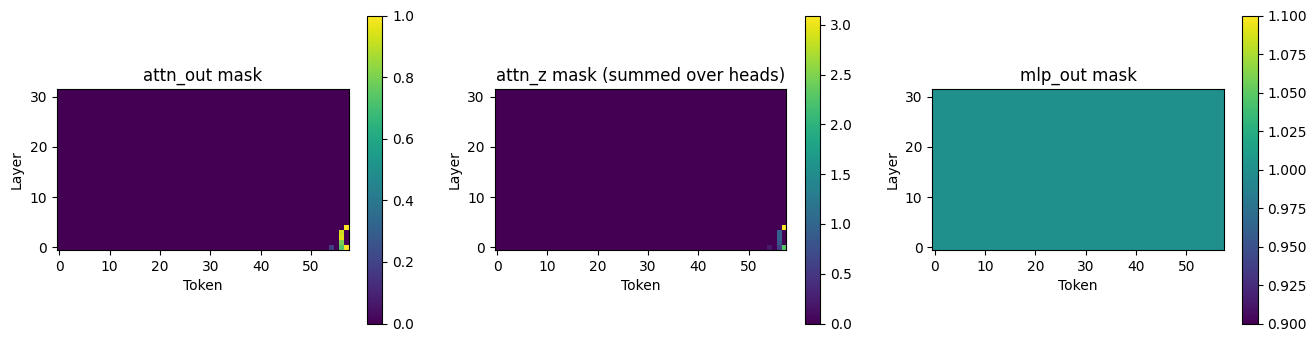

In [41]:
# Plot heatmap of attention mask
prompt = hi_attn_df.prompt_c[0]
tokens = mtl_model.tl_model.to_tokens(prompt)[0]
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + utils.tokenize_to_strs(prompt, tl_model)[1:],
        np.arange(len(tokens)),
    )
)

for token_idx in range(mtl_model.n_tokens):
    for layer_idx in range(32):
        for head_idx in range(mtl_model.tl_model.cfg.n_heads):
            weight_attn = attn_z_mask[layer_idx, token_idx, head_idx]
            if weight_attn > 0:
                print(
                    f"T{token_idx} L{layer_idx}H{head_idx}ATN weight={weight_attn}"
                )

        # weight_mlp = mlp_mask[layer_idx, token_idx]
        # if weight_mlp > 0:
        #     print(f"T{token_idx} L{layer_idx}MLP weight={weight_mlp}")

for token_idx_q in range(mtl_model.n_tokens):
    for layer_idx in range(32):
        for head_idx in range(mtl_model.tl_model.cfg.n_heads):
            for token_idx_k in range(mtl_model.n_tokens):
                weight = attn_pattern_mask[
                    layer_idx, head_idx, token_idx_q, token_idx_k
                ]
                if weight > 0:
                    q_token = mtl_model.tl_model.to_string(tokens[token_idx_q])
                    k_token = mtl_model.tl_model.to_string(tokens[token_idx_k])
                    print(
                        f"T{token_idx_q} L{layer_idx}H{head_idx}"
                        f" -> k{token_idx_k}"
                        f" {weight=}"
                    )

plt.figure(figsize=(16, 4))
# plt.suptitle(tokenized_subprompt)

plt.subplot(1, 3, 1)
plt.imshow(attn_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_out mask")

plt.subplot(1, 3, 2)
plt.imshow(attn_z_mask.sum(axis=-1), origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_z mask (summed over heads)")

plt.subplot(1, 3, 3)
plt.imshow(mlp_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("mlp_out mask")

plt.show()

In [46]:
f_attn_prob_mean = 0

def get_f_attn_prob(
    pattern: Float[torch.Tensor, "b head seqQ seqK"],
    hook: HookPoint,
):
    global f_attn_prob_mean
    f_attn_prob_mean = pattern[:, HEAD, -1, 35].mean()
    return pattern

mtl_model.zero_threshold = 0.05
mtl_model.one_threshold = 0.05
with torch.no_grad():
    mtl_model.tl_model.run_with_hooks(
        list(hi_attn_df.prompt_c),
        fwd_hooks=[[tl_utils.get_act_name("pattern", LAYER), get_f_attn_prob]],
    )

print(f_attn_prob_mean)

tensor(0.3105, device='cuda:0')


### Analyze thresholding

In [18]:
f_attn_prob_mean = 0

def get_f_attn_prob(
    pattern: Float[torch.Tensor, "b head seqQ seqK"],
    hook: HookPoint,
):
    global f_attn_prob_mean
    f_attn_prob_mean = pattern[:, HEAD, -1, 35].mean()
    return pattern

all_mask_values = (
    torch.cat([mask.flatten() for mask in mtl_model.masks.values()])
    .detach()
    .cpu()
    .numpy()
)

thresholds = np.unique(
    np.sort(np.concatenate([np.sort(all_mask_values)[::10], np.array([0, 1])]))
)
thresh_metrics = []
for thresh in tqdm(thresholds):
    mtl_model.zero_threshold = thresh
    mtl_model.one_threshold = 1
    with torch.no_grad():
        mtl_model.tl_model.run_with_hooks(
            list(hi_attn_df.prompt_c),
            fwd_hooks=[[tl_utils.get_act_name("pattern", LAYER), get_f_attn_prob]],
        )
        f_attn_prob_mean_0 = f_attn_prob_mean.item()

    mtl_model.zero_threshold = 0
    mtl_model.one_threshold = max(thresh, 1e-9)
    with torch.no_grad():
        mtl_model.tl_model.run_with_hooks(
            list(hi_attn_df.prompt_c),
            fwd_hooks=[[tl_utils.get_act_name("pattern", LAYER), get_f_attn_prob]],
        )
        f_attn_prob_mean_1 = f_attn_prob_mean.item()

    thresh_metrics.append(
        dict(
            threshold=thresh,
            f_attn_prob_mean_0=f_attn_prob_mean_0,
            f_attn_prob_mean_1=f_attn_prob_mean_1,
            n_nonzero=(all_mask_values > thresh).sum(),
            n_ones=(all_mask_values > thresh).sum(),
        )
    )

  0%|          | 0/3 [00:00<?, ?it/s]

# nonzero mask values: 12
# total mask values: 3507840


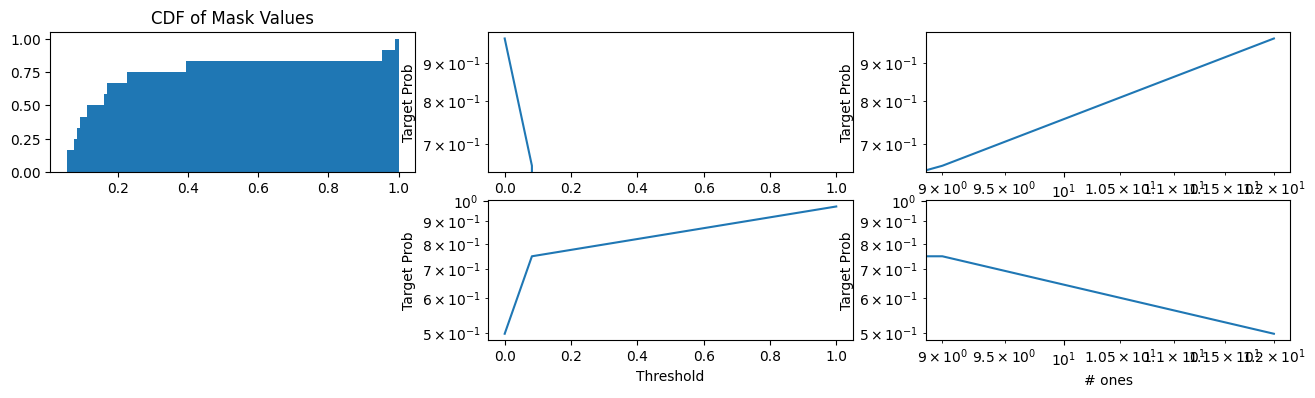

In [19]:
df_thresh = pd.DataFrame(thresh_metrics)

print("# nonzero mask values:", (all_mask_values > 0).sum())
print("# total mask values:", all_mask_values.size)

plt.figure(figsize=(16, 4))
plt.subplot(2, 3, 1)
plt.hist(
    all_mask_values[all_mask_values > 0],
    cumulative=True,
    bins=100,
    density=True,
)
plt.title("CDF of Mask Values")

plt.subplot(2, 3, 2)
plt.plot(df_thresh.threshold, df_thresh.f_attn_prob_mean_0)
plt.yscale("log")
plt.xlabel("0 Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 3)
plt.plot(df_thresh.n_nonzero, df_thresh.f_attn_prob_mean_0)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# non-zero mask values")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 5)
plt.plot(df_thresh.threshold, df_thresh.f_attn_prob_mean_1)
plt.yscale("log")
plt.xlabel("Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 6)
plt.plot(df_thresh.n_ones, df_thresh.f_attn_prob_mean_1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# ones")
plt.ylabel("Target Prob")
plt.show()